# COMMUNICATE WITH OTHER JUPYTER FILES

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    


In [2]:
sys.meta_path.append(NotebookFinder())

In [8]:
%matplotlib inline
import sklearn
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import scipy
import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
cmap = sns.cm.rocket_r
from utils1 import GENRE_DIR, GENRE_LIST
from sklearn.externals import joblib
from random import shuffle

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [4]:
def plot_confusion_matrix(y_test, y_pred, labels, ymap=None):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args:
      y_test:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_test, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_test = [ymap[yi] for yi in y_test]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_test, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'


    fig, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,  cmap = cmap, linewidths=.5)
    plt.tight_layout()
    plt.show()


"""reads FFT-files and prepares X_train and y_train.
genre_list must consist of names of folders/genres consisting of the required FFT-files
base_dir must contain genre_list of directories
"""
def read_fft(genre_list, base_dir):
	X = []
	y = []
	for label, genre in enumerate(genre_list):
		# create UNIX pathnames to id FFT-files.
		genre_dir = os.path.join(base_dir, genre, "*.fft.npy")
		# get path names that math genre-dir
		file_list = glob.glob(genre_dir)
		for file in file_list:
			fft_features = np.load(file)
			X.append(fft_features)
			y.append(label)

	return np.array(X), np.array(y)

In [5]:
"""reads MFCC-files and prepares X_train and y_train.
genre_list must consist of names of folders/genres consisting of the required MFCC-files
base_dir must contain genre_list of directories
"""
def read_ceps(genre_list, base_dir):
	X= []
	y=[]
	for label, genre in enumerate(genre_list):
		for fn in glob.glob(os.path.join(base_dir, genre, "*.ceps.npy")):
			ceps = np.load(fn)
			num_ceps = len(ceps)
			X.append(np.mean(ceps[int(num_ceps*1/10):int(num_ceps*9/10)], axis=0))
			#X.append(ceps)
			y.append(label)

	print(np.array(X).shape)
	print(len(y))
	return np.array(X), np.array(y)

In [6]:
def learn_and_classify(X_train, y_train, X_test, y_test, genre_list):


	print(len(X_train))
	print(len(X_train[0]))

	#Logistic Regression classifier

	logistic_classifier = linear_model.logistic.LogisticRegression()
	logistic_classifier.fit(X_train, y_train)
	logistic_predictions = logistic_classifier.predict(X_test)
	logistic_accuracy = accuracy_score(y_test, logistic_predictions)
	logistic_cm = confusion_matrix(y_test, logistic_predictions)
	print("logistic accuracy = " + str(logistic_accuracy))
	print("logistic_cm:")
	print(logistic_cm)

	#change the pickle file when using another classifier eg model_mfcc_fft

	joblib.dump(logistic_classifier, 'saved_models/model_mfcc_log.pkl')

	#K-Nearest neighbour classifier

	knn_classifier = KNeighborsClassifier()
	knn_classifier.fit(X_train, y_train)
	knn_predictions = knn_classifier.predict(X_test)
	knn_accuracy = accuracy_score(y_test, knn_predictions)
	knn_cm = confusion_matrix(y_test, knn_predictions)
	print("knn accuracy = " + str(knn_accuracy))
	print("knn_cm:")
	print(knn_cm)
	joblib.dump(knn_classifier, 'saved_models/model_mfcc_knn.pkl')

	plot_confusion_matrix(y_test=y_test, y_pred=logistic_predictions ,labels=genre_list, ymap=None)
	plot_confusion_matrix(y_test=y_test, y_pred=knn_predictions, labels=genre_list, ymap=None)



(457, 13)
457
new1 (365, 13)
**************************************USING MFCC*****************************
365
13
logistic accuracy = 0.7391304347826086
logistic_cm:
[[11  1  6  1  6]
 [ 1 15  0  0  0]
 [ 3  1  8  3  0]
 [ 1  0  0 13  1]
 [ 0  0  0  0 21]]
knn accuracy = 0.7934782608695652
knn_cm:
[[17  1  2  0  5]
 [ 0 16  0  0  0]
 [ 0  1 12  2  0]
 [ 2  0  2 10  1]
 [ 1  0  0  2 18]]


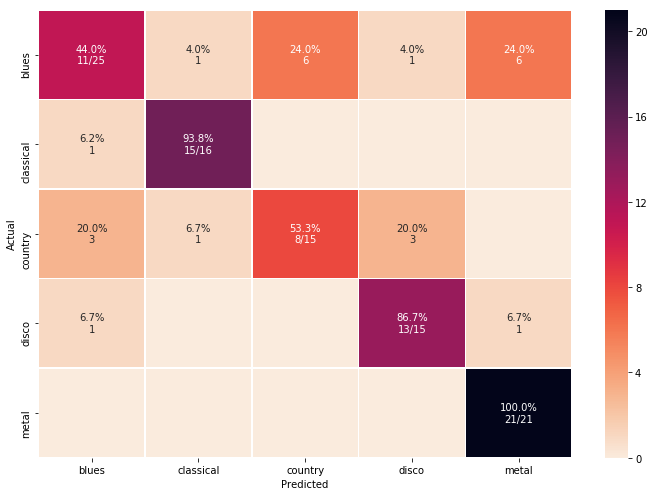

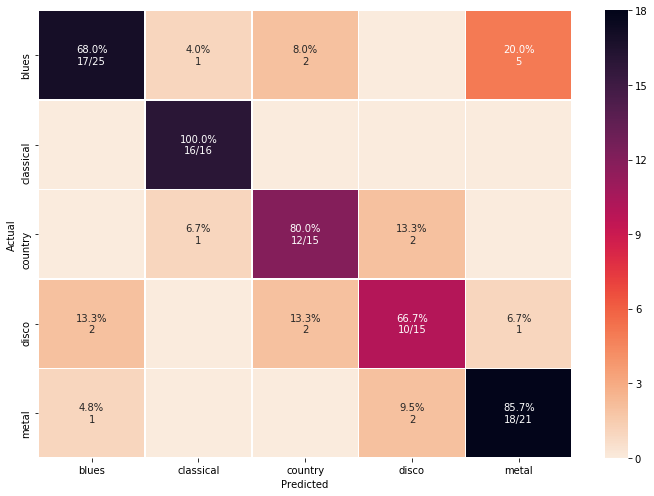

In [9]:
base_dir_fft  = GENRE_DIR
base_dir_mfcc = GENRE_DIR

"""list of genres (these must be folder names consisting .wav of respective genre in the base_dir)
Change list if needed.
"""
genre_list =  "blues","classical","country","disco","metal"

#genre_list = ["classical", "jazz"] IF YOU WANT TO CLASSIFY ONLY CLASSICAL AND JAZZ

#use FFT
# X, y = read_fft(genre_list, base_dir_fft)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)
# print('\n******USING FFT******')
# learn_and_classify(X_train, y_train, X_test, y_test, genre_list)
# print('*********************\n')

#use MFCC
X,y= read_ceps(genre_list, base_dir_mfcc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)
print("new1",X_train.shape)


print('**************************************USING MFCC*****************************')
learn_and_classify(X_train, y_train, X_test, y_test, genre_list)